## Statistical Analysis of Medical Insurance Claims

Link to Dataset: https://www.kaggle.com/datasets/mirichoi0218/insurance

Dataset Information:

- age: age of primary beneficiary

- sex: insurance contractor gender, female, male

- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

- children: Number of children covered by health insurance / Number of dependents

- smoker: Smoking

- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

- charges: Individual medical costs billed by health insurance

## Importing the libraries and dataset

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [2]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Summary of the dataset

In [3]:
df.sex=df['sex'].astype("category")
df.smoker=df['smoker'].astype("category")
df.region=df['region'].astype("category")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB


Our dataset has the following types of variables:
- Categorical varibles: sex, smoker, region, children
- Quantitative variables: age, bmi, charges. Here children is a discrete variable where as age, bmi, and charges are continous variables.

## Check for missing values

In [5]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## Descriptive Statistics of the Dataset

This shows us statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values. 

In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


**Observations:**
The following is observed from the descriptive statistics of the dataset.

- The average age of the primary beneficiary is 39.2 with the minimum age being 18 and maximum being 64.

- The average BMI is 30.66. The maximum BMI is 53.13 while the minimum is 15.96.

- On an average, the customer has 1 child.

- For `age`, `bmi` and `children`, the mean is almost equal to the median, suggesting that the data is normally distrubuted.

- The Average medical costs billed to health insurance is 13270, median is 9382, minimum is 1121.87 and maximum is 63770. The median of charges is less than the mean of charges which means that the distribution is positively skewed.

In [7]:
df.describe(include='category')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [8]:
# Getting counts of the unique observations for each categorical variable 
column_lst =  df.select_dtypes(['category']).columns
for i in range(len(column_lst)):
    print(df[column_lst[i]].value_counts())

male      676
female    662
Name: sex, dtype: int64
no     1064
yes     274
Name: smoker, dtype: int64
southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64


**Observations:**
From the above, we can infer that:
- There are slightly more 'male' beneficiaries in the dataset compared to 'female' beneficiaries.
- Most of the benficiaries are non-smokers.
- Number of claims made by customers who live in the southeast region of the United States is more compared to other regions.

## Exploratory Data Analysis

### Univariate Analysis

##### Box Plot

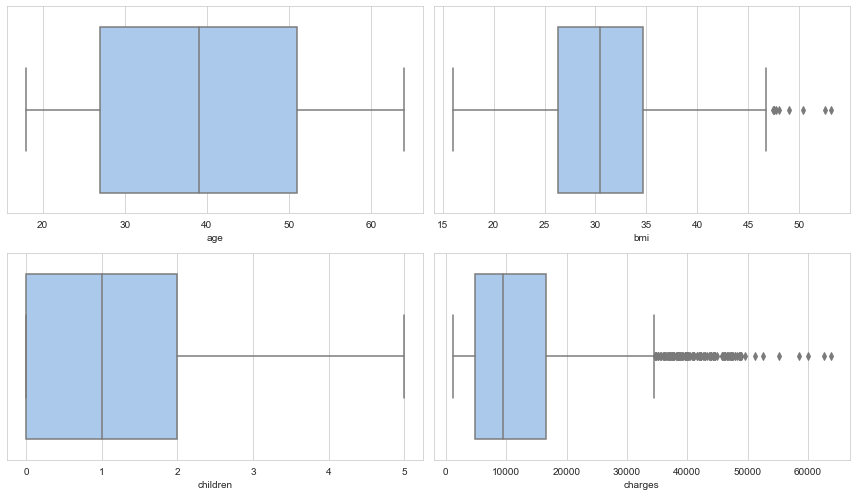

In [9]:
cols = 2
rows = 2
sns.set_palette("pastel")
sns.set_style("whitegrid")
num_cols = df.select_dtypes(exclude='category').columns
fig = plt.figure(figsize= (12,7))
for i, col in enumerate(num_cols):
    ax=fig.add_subplot( rows, cols, i+1)
    sns.boxplot(x=df[col], ax=ax)
    
fig.tight_layout()  
plt.show()

##### Histogram and Rug Plot

In [10]:
def plot_rug_hist(col_name):
    plt.figure(figsize= (12,7))
    sns.rugplot(x=col_name, data=df, height=.03, color='darkblue')
    sns.histplot(x=col_name, data=df, kde=True)
    plt.axvline(df[col_name].mean(), color='red', linestyle='--',linewidth=2, label='Mean')
    plt.axvline(df[col_name].median(), color='green', linestyle='--',linewidth=2, label='Median')
    plt.axvline(df[col_name].mode().tolist()[0], color='yellow', linestyle='--',linewidth=2, label='Mode')
    plt.legend()
    plt.show()

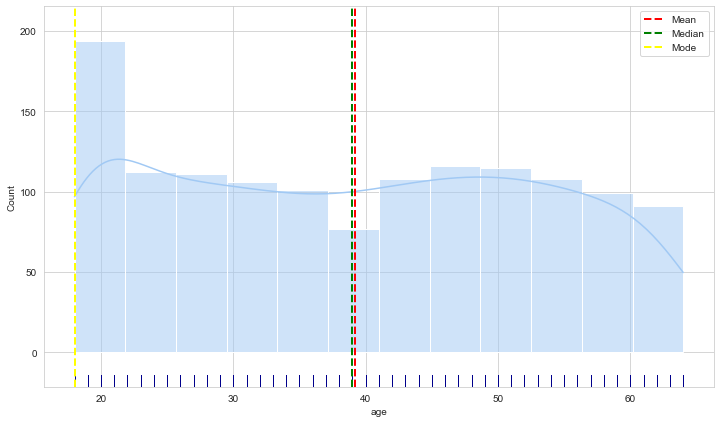

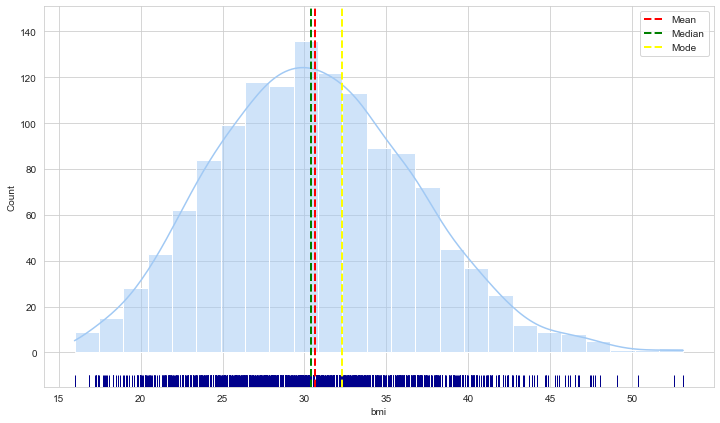

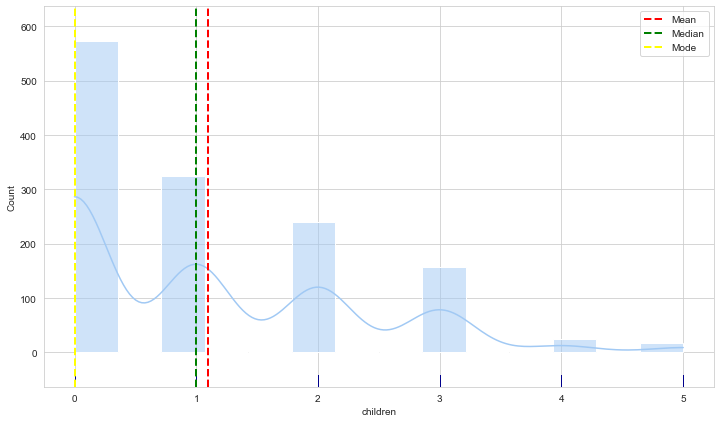

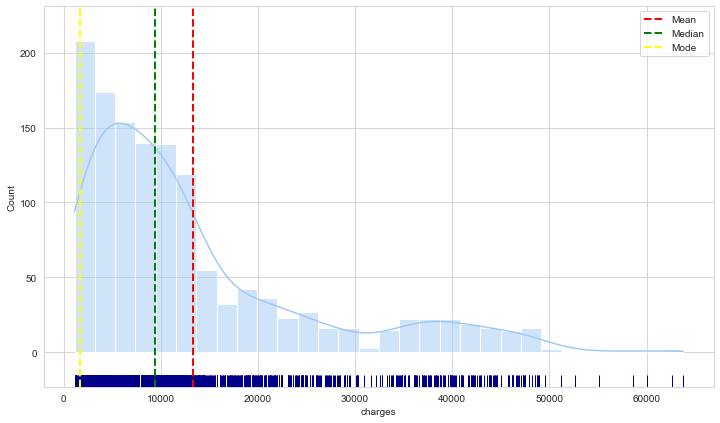

In [11]:
for i, col in enumerate(num_cols):
    plot_rug_hist(num_cols[i])

**Observations:**

- The age of primary beneficary lies approximately between 20 - 65 years. Since the mode is 18, we can safely say that majority of customer are 18 years old.
- BMI is normally distrubuted and the average BMI among the beneficiaries is 30 which is outside the normal range of BMI. It is also observed that there are lot of outliers at upper end.
- Majority of the beneficary have no children.
- The distribution for charges distrubution is unimodal and is right-skewed. There are lot of outliers at upper end.

##### Bar Plot

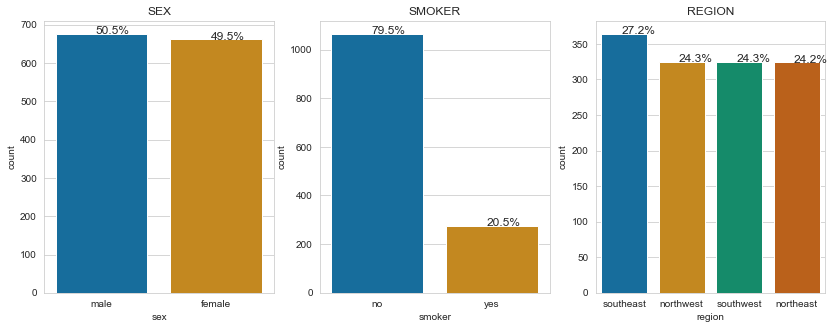

In [12]:
# Function to create barplots that indicate percentage of data for each category.
def percent_bar_plot(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y), size = 12)
        
# Plot the Bar Chart
cat_cols =  df.select_dtypes(['category']).columns
fig, axes =plt.subplots(1,3,figsize=(14, 5))
for i in range(len(cat_cols)):
    order = df[cat_cols[i]].value_counts(ascending=False).index
    axis = sns.countplot(x=cat_cols[i], data=df, order=order, ax=axes[i], palette='colorblind').set(title=cat_cols[i].upper())
    percent_bar_plot(axes[i], df[cat_cols[i]])

**Observations:**

- 50.5% of the beneficiaries are male and 49.5% are female. So we approximately have the same number of male and female beneficiaries.
- Only 20.5% of beneficary are smokers. Most of our beneficiaries are non-smokers.
- As observed from the chart, our beneficaries are evenly distributed across regions with South East being the most populous one (27.2%) with the rest of regions each containing around 24% approximately.

### Bivariate and Multivariate Analysis

##### Correlation among Features

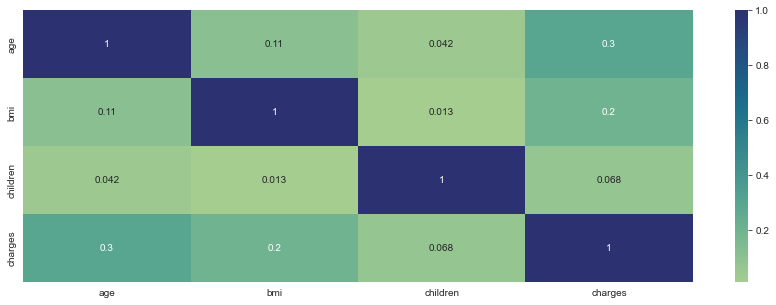

In [13]:
plt.figure(figsize=(15,5))
sns.heatmap(df.corr(), annot=True, cmap='crest')
plt.show()

**Observations:**
- We see that there is slighly significant positive correlation betweem `age` and `charges` & `bmi` and `charges`.

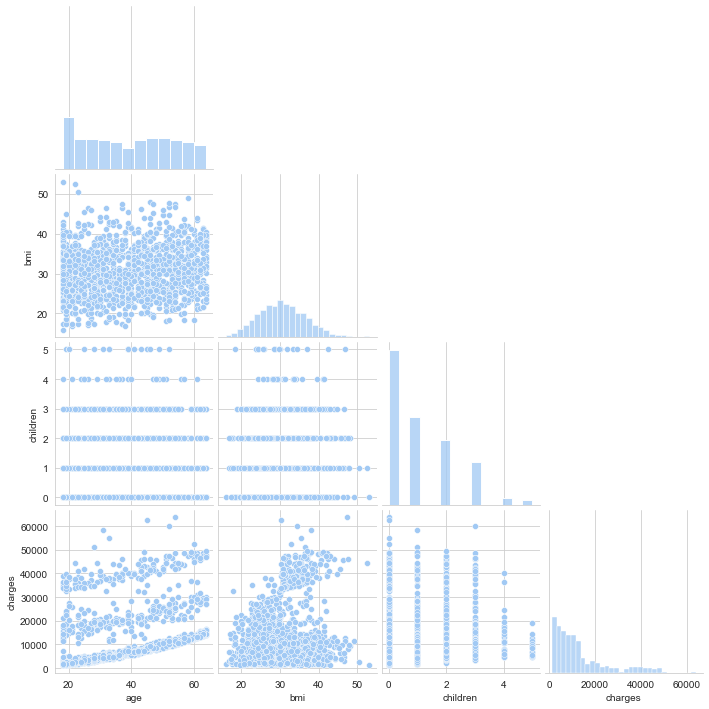

In [14]:
sns.pairplot(data=df, corner=True)
plt.show()

**Observations:**
- We can see that there is almost a slight linear increase in `charges` with increase in `age` which makes sense as medical bills increase as one gets older.
- We also observe that people with higher `bmi` pay more `charges` than people with lower `bmi`.

##### Sex vs All Numerical Features

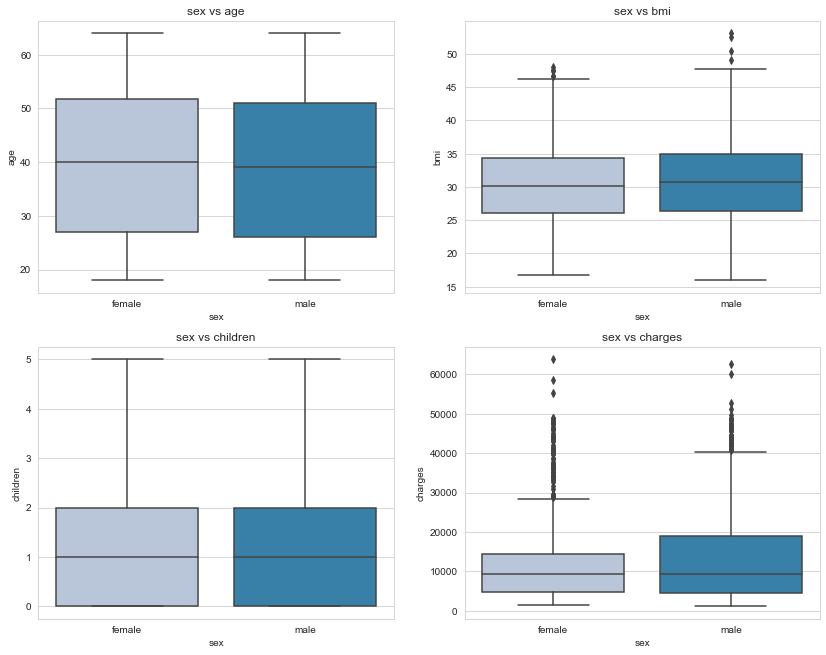

In [15]:
def cat_vs_all_numerical(feature):
    fig, axes =plt.subplots(2,2,figsize=(14, 11))
    for i in range(len(num_cols)):
        row = i//2
        col = i%2
        ax = axes[row, col]
        sns.boxplot(y=df[num_cols[i]], x=df[feature], ax=ax, palette="PuBu", orient='v').set(title='{} vs '.format(feature)+ num_cols[i])
        
cat_vs_all_numerical('sex')

**Observations:**

- Average age of female beneficiaries is slightly higher than the male beneficiaries.
- No. of children from both male and female beneficary have is same.
- BMI of male beneficiaries has many outliers and average BMI of male is slightly higher than female.
- Male beneficiaries have incurred more charges to insurance compared to female beneficiaries. There are lot of outliers in female beneficiaries.

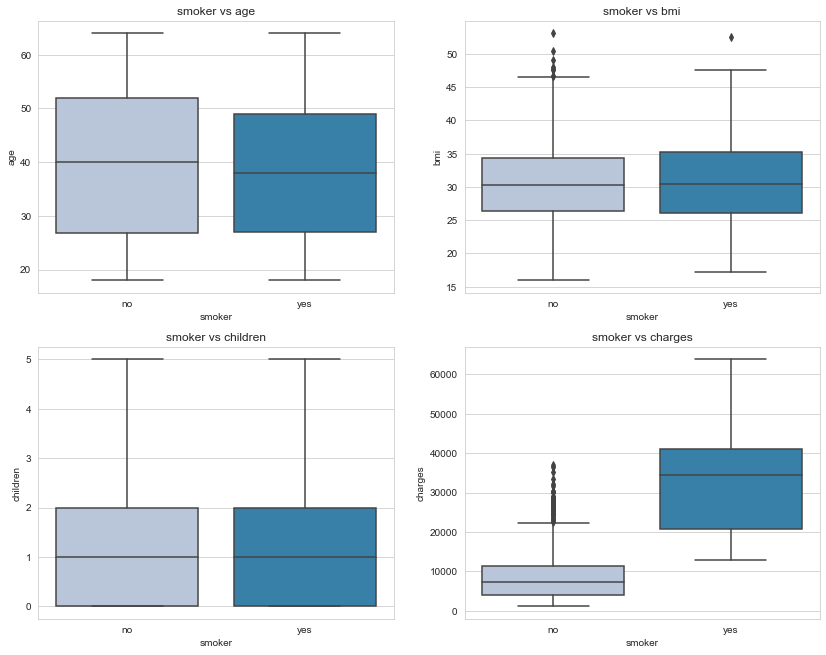

In [16]:
cat_vs_all_numerical('smoker')

**Observations:**
- Smokers have incured more cost for insurance than nonsmoker beneficiaries. Non-smokers also have a lot of outliers.
- The BMI of non smokers has a lot of outliers.

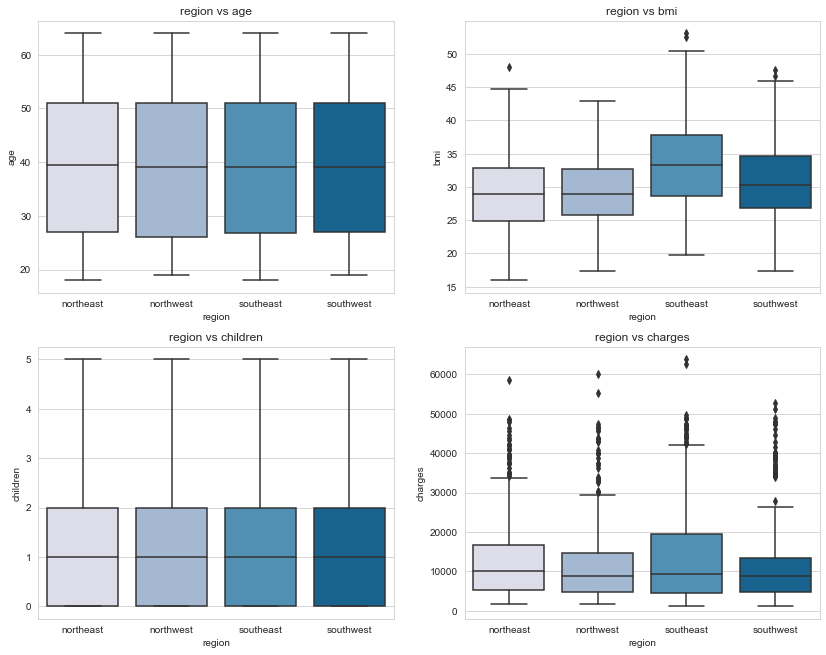

In [17]:
cat_vs_all_numerical('region')

**Observations**:

- The age and numnber of children across regions is almost the same.
- The average BMI of beneficiaries from southeast is higher compared to other regions.
- Beneficiaries from the southeast have incurred more charges compared to the beneficiaries from other regions.
- We observe a lot of outliers in the region vs charges box plots.

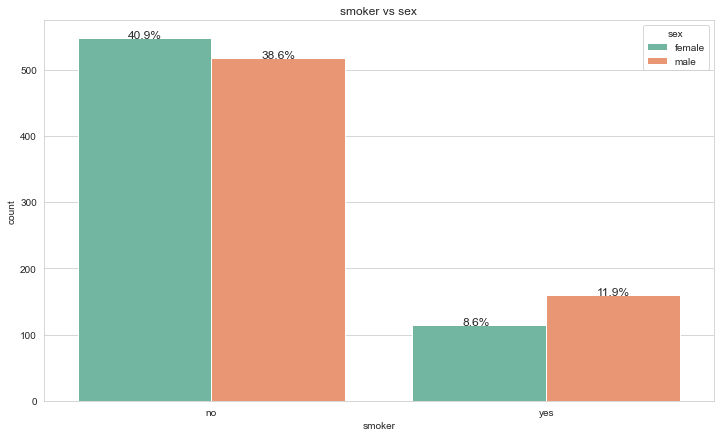

In [18]:
def compare_bar_plots(feature1, feature2):
    plt.figure(figsize=(12, 7))
    ax=sns.countplot(x=feature1, hue=feature2, data=df, palette='Set2')
    percent_bar_plot(ax, df[feature2])
    ax.set(title="{} vs {}".format(feature1, feature2))
    
compare_bar_plots('smoker', 'sex')

**Observation:**
- Among non-smokers, we have more females than males.
- On the other hand, we have more male smokers (3.3% higher) than female smokers.

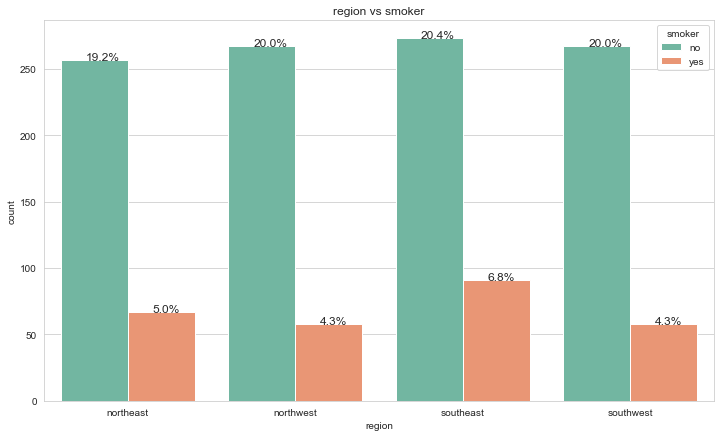

In [19]:
compare_bar_plots('region', 'smoker')

**Observations**:
- It is observed that there is roughly the same percentage of non-smokers across all regions.
- The northwest and southwest regions have relatively lower percentage of smokers. The southeast region has the highest percentage of smokers among all regions at 6.8%.

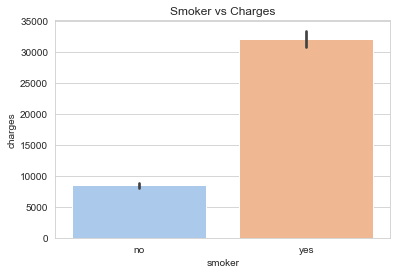

In [20]:
sns.barplot(x=df.smoker, y=df.charges).set(title="Smoker vs Charges");

**Observations**:
- Smokers have higher charges in insurance claims than non-smokers.

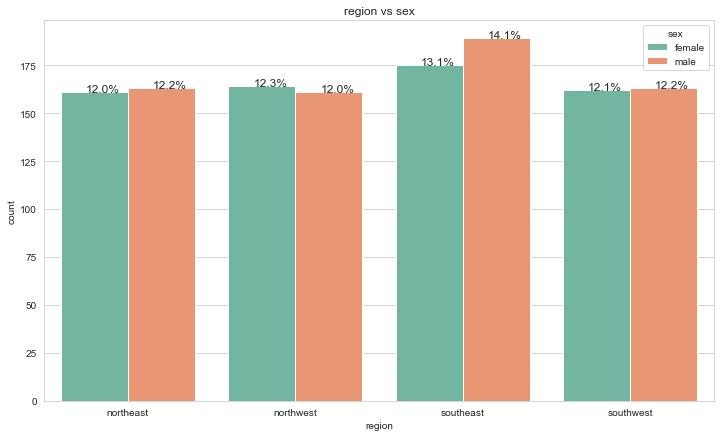

In [21]:
compare_bar_plots('region', 'sex')

**Observations:**
- With the exception of the southeast region, there is hardly any difference between the number of male and female beneficiaries.

In [22]:
df.groupby(df.sex).charges.mean()

sex
female    12569.578844
male      13956.751178
Name: charges, dtype: float64

**Observations:**
- The mean charges in insurance claims of males is higher than that of females.

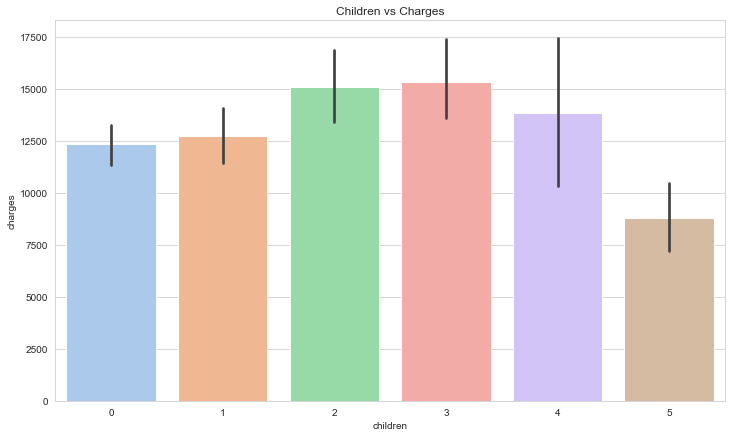

In [23]:
plt.figure(figsize=(12, 7))
sns.barplot(x=df.children, y=df.charges).set(title="Children vs Charges");

**Observations:**
- People with 2-3 children as dependents on the insurance had higher claim charges.

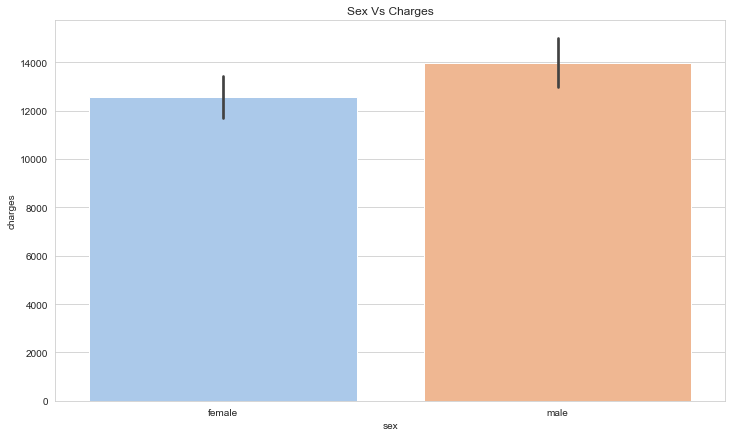

In [24]:
plt.figure(figsize=(12, 7))
sns.barplot(x=df.sex, y=df.charges).set(title='Sex Vs Charges');

**Observations:**
- Male beneficiaries had higher claim charges than female beneficiaries.

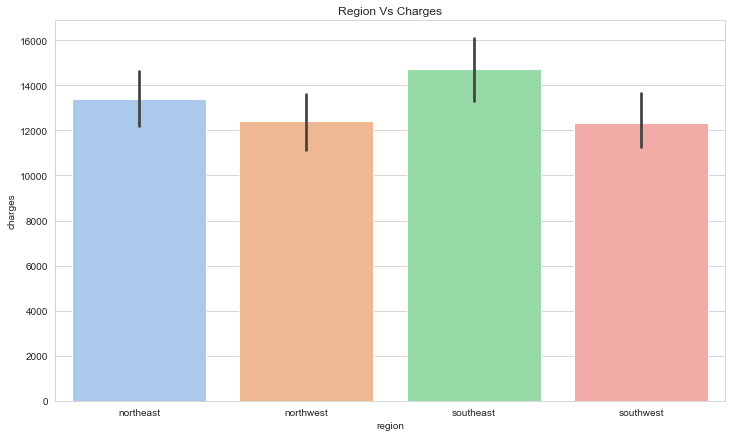

In [25]:
plt.figure(figsize=(12, 7))
sns.barplot(x='region',y='charges',data=df).set(title='Region Vs Charges');

**Observations:**
- Beneficiaries in the southeast have higher claim charges than other regions.

C:\Users\kedar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


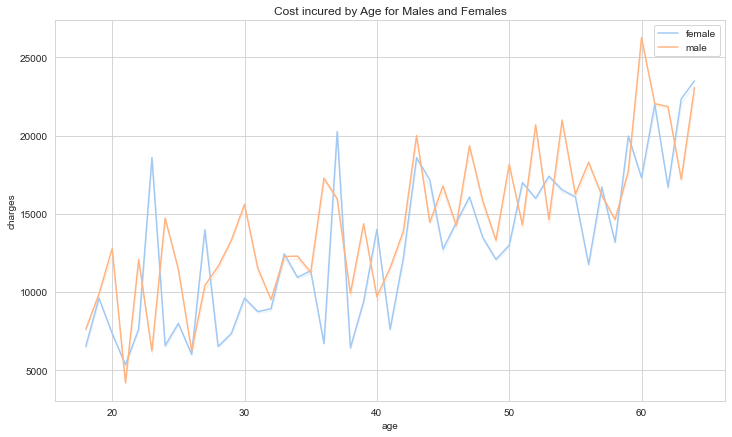

In [26]:
plt.figure(figsize=(12,7))
sns.lineplot(df['age'], df['charges'], hue=df['sex'], ci=0).set(title= 'Cost incured by Age for Males and Females')
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

**Observations:**
- With increasing age, the charges has increased for both males and females.
- There some spikes for female at an approximately at the ages of 23, 28 and 43.

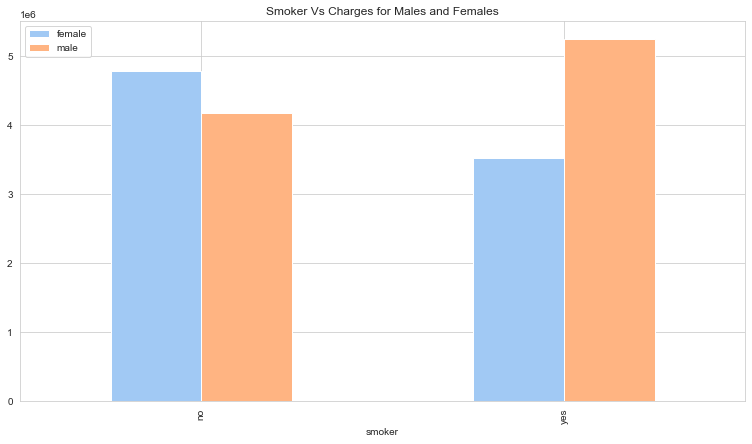

In [27]:
df_smoker_char_sex = pd.crosstab(index=df.smoker,columns=df.sex ,values=df.charges, aggfunc='sum')
fig1, axes1 = plt.subplots(1,1,figsize=(13, 7))
df_smoker_char_sex.plot(kind='bar', ax=axes1, title="Smoker Vs Charges for Males and Females")
plt.legend(loc='upper left')
plt.show()

**Observations:**
- Males who smoke have the most claims and have higher charges.
- Number of claims made by females who dont smoke is more compared to females who smoke.

##### Grouping The Data By BMI of Policy Holders

In [28]:
category = pd.cut(df.bmi, bins=[15,25,35,45,55], labels=['15-25','25-35','35-45','45-55'])
df.insert(5, 'BMIGroup', category)

In [29]:
df.head()

,age,sex,bmi,children,smoker,BMIGroup,region,charges
0,19,female,27.900,0,yes,25-35,southwest,16884.92400
1,18,male,33.770,1,no,25-35,southeast,1725.55230
2,28,male,33.000,3,no,25-35,southeast,4449.46200
3,33,male,22.705,0,no,15-25,northwest,21984.47061
4,32,male,28.880,0,no,25-35,northwest,3866.85520


In [30]:
df.groupby(df.BMIGroup).charges.mean()

BMIGroup
15-25    10284.290025
25-35    12720.254311
35-45    16913.681515
45-55    17547.926750
Name: charges, dtype: float64

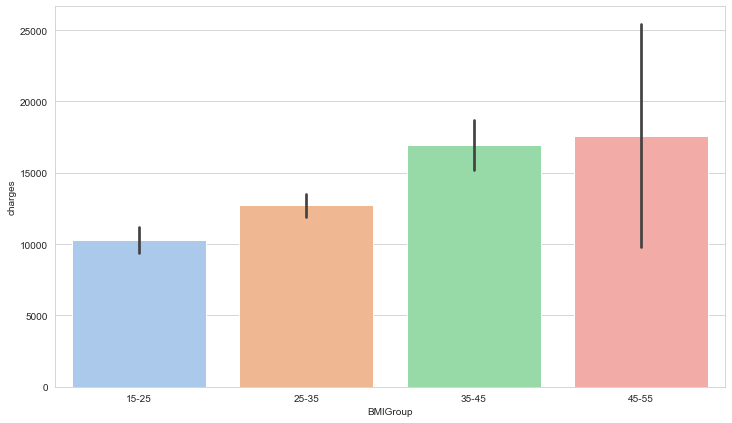

In [31]:
plt.figure(figsize=(12,7))
sns.barplot(x=df.BMIGroup, y=df.charges);

**Observations:**
- People with a lower BMI have lower charges compared to people with higher BMIs.

##### Grouping The Data By Age of Policy Holders

In [32]:
category1 = pd.cut(df.age, bins=[18,28,38,48,58,68], labels=['18-28','28-38','38-48','48-58','58-68'])
df.insert(6,'AgeBin', category1)

In [33]:
df.groupby(df.AgeBin).charges.mean()

AgeBin
18-28     9528.142786
28-38    11598.554943
38-48    14334.585843
48-58    15887.954341
58-68    20824.972901
Name: charges, dtype: float64

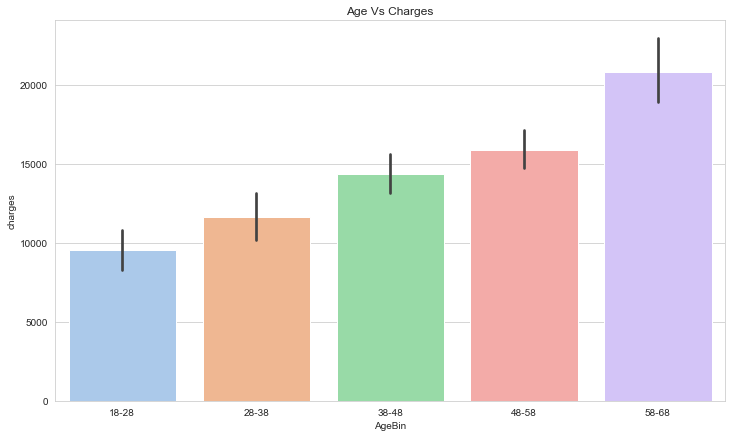

In [34]:
plt.figure(figsize=(12,7))
sns.barplot(x=df.AgeBin, y=df.charges).set(title='Age Vs Charges');

**Observations:**
- People with a lower age range have lower charges compared to older people.

##### Mean Charges by Smokers by Sex in different regions

In [35]:
df.groupby(['region','sex','smoker']).mean()['charges'].unstack()

smoker                     no           yes
region    sex                              
northeast female  9640.426984  28032.046398
          male    8664.042222  30926.252583
northwest female  8786.998679  29670.824946
          male    8320.689321  30713.181419
southeast female  8440.205552  33034.820716
          male    7609.003587  36029.839367
southwest female  8234.091260  31687.988430
          male    7778.905534  32598.862854

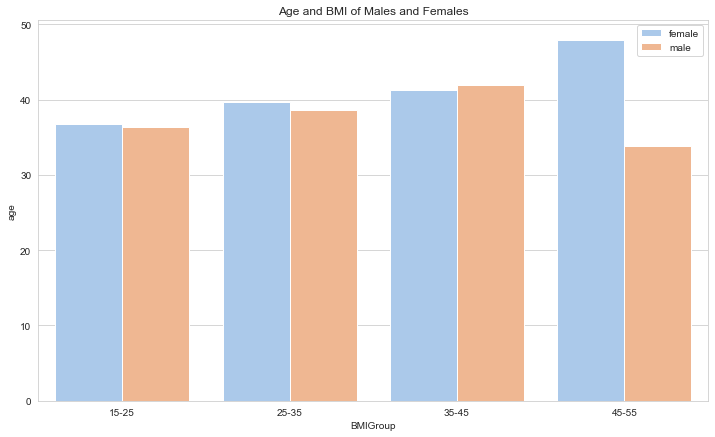

In [36]:
plt.figure(figsize=(12,7))
sns.barplot(x=df["BMIGroup"], y=df["age"], hue=df['sex'], ci=0).set(title= 'Age and BMI of Males and Females')
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

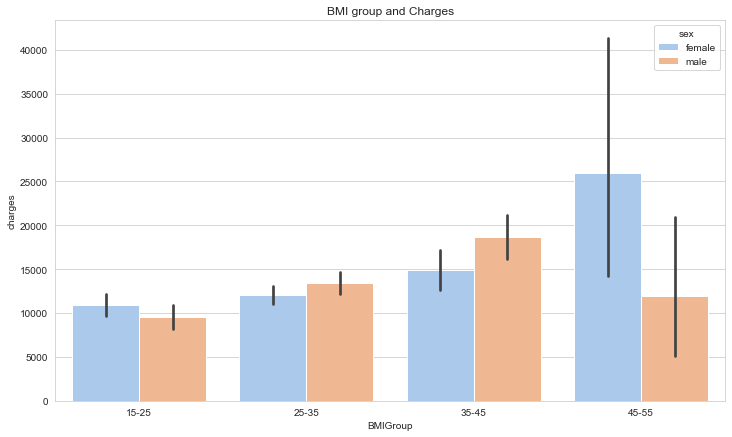

In [37]:
plt.figure(figsize=(12,7))
sns.barplot(x='BMIGroup', y='charges', hue='sex', data=df).set(title="BMI group and Charges");

**Observations:**
- Females with most BMI has incured most charges in insurance claims.

In [38]:
pd.crosstab(df['sex'], df['children'])

children,0,1,2,3,4,5
sex,,,,,,
female,289,158,119,77,11,8
male,285,166,121,80,14,10


<Figure size 864x576 with 0 Axes>

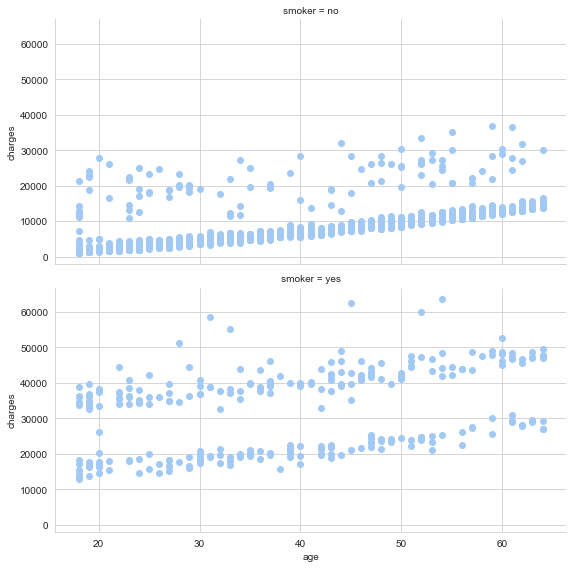

In [39]:
plt.figure(figsize=(12,8))
g=sns.FacetGrid(df, row='smoker', height=4, aspect=2)
g=(g.map(plt.scatter ,'age','charges').add_legend());

**Observations:**
- Young people who don't smoke have lowest insurance charges and non-smokers have a steady linear but low rise in charges.
- However, smokers in general, regardless of their age have higher insurance claim charges.

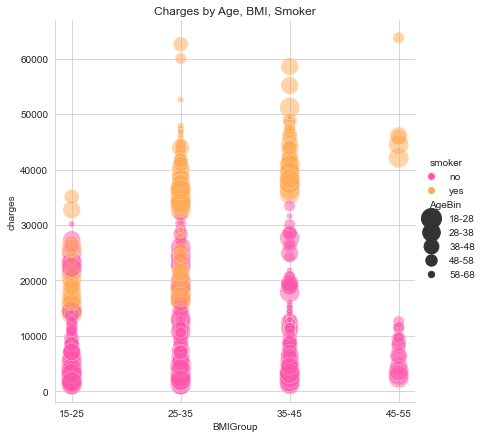

In [40]:
sns.relplot(x=df.BMIGroup, y=df.charges, hue=df.smoker, size= df.AgeBin,
            sizes=(40, 400), alpha=.5, palette="spring",
            height=6, data=df).set(title='Charges by Age, BMI, Smoker')
plt.show();

**Observations:**
- Males who smoke have incured more cost compared to nonsmokers.
- As age increased claims increased - Smokers have higher medical claims.
- High BMI and smokers have high insurance claim charges.

### Conclusions Based on Exploratory Data Analysis

- Insurances charges increases as age of the beneficiary increases.
- Males who smoke have higher charges.
- Females who are nonsmoker also have more claims to nonsmoker males and most of the time at a younger age. This may be because of child birth.
- Customer with BMI >30 are ones with high obesity. They have more health issues and have higher claims.

## Statistical Analysis

### 1. To Prove or Disprove that the medical claims made by the people who smoke is greater than those who don't.

**Step 1:** Define the null and alternative hypothesis.

H<sub>0</sub>:μ<sub>1</sub><=μ<sub>2</sub>  The average charges of smokers is less than or equal to nonsmokers.

H<sub>a</sub>:μ<sub>1</sub>>μ<sub>2</sub>  The average charges of smokers is greater than nonsmokers.

**Step 2:** Decide the significance level. If P values is less than alpha, reject the null hypothesis.

α = 0.05

**Step 3:** Identify the test

Since the standard deviation of the population is not known, a T-test will be performed. The > sign in alternate hypothesis indicates that the test is right tailed, meaning that all z values that would cause us to reject null hypothesis are in just one tail to the right of sampling distribution curve.

**Step 4:** Calculate the test-statistics and p-value

In [41]:
smoker = df.loc[df.smoker=="yes"]
smoker.head()

,age,sex,bmi,children,smoker,BMIGroup,AgeBin,region,charges
0,19,female,27.90,0,yes,25-35,18-28,southwest,16884.9240
11,62,female,26.29,0,yes,25-35,58-68,southeast,27808.7251
14,27,male,42.13,0,yes,35-45,18-28,southeast,39611.7577
19,30,male,35.30,0,yes,35-45,28-38,southwest,36837.4670
23,34,female,31.92,1,yes,25-35,28-38,northeast,37701.8768


In [42]:
smoker.count()

age         274
sex         274
bmi         274
children    274
smoker      274
BMIGroup    274
AgeBin      262
region      274
charges     274
dtype: int64

In [43]:
nonsmoker = df.loc[df.smoker=='no']
nonsmoker.head()

,age,sex,bmi,children,smoker,BMIGroup,AgeBin,region,charges
1,18,male,33.770,1,no,25-35,NaN,southeast,1725.55230
2,28,male,33.000,3,no,25-35,18-28,southeast,4449.46200
3,33,male,22.705,0,no,15-25,28-38,northwest,21984.47061
4,32,male,28.880,0,no,25-35,28-38,northwest,3866.85520
5,31,female,25.740,0,no,25-35,28-38,southeast,3756.62160


In [44]:
nonsmoker.count()

age         1064
sex         1064
bmi         1064
children    1064
smoker      1064
BMIGroup    1064
AgeBin      1007
region      1064
charges     1064
dtype: int64

In [45]:
# Adjusting the size of the rows to be equal
nonsmoker = nonsmoker[-274:]
charges_yes = smoker.charges
charges_no = nonsmoker.charges

In [46]:
print('Average Cost charged to Insurance for smoker is {} and nonsmoker is {} '.format(charges_yes.mean(),charges_no.mean()))

Average Cost charged to Insurance for smoker is 32050.23183153285 and nonsmoker is 8441.24905576642 


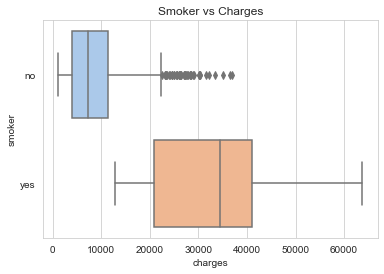

In [49]:
#smoker vs charges
sns.boxplot(x = df.charges, y = df.smoker, data = df).set(title="Smoker vs Charges");

In [53]:
alpha=0.05
t_statistic_1, p_value_1 = ttest_ind(charges_yes, charges_no)
p_value_onetail=p_value_1/2

print("Test statistic = {} , P value ={} , One tail P value = {}".format(t_statistic_1,p_value_1, p_value_onetail ))

Test statistic = 30.168384427571915 , P value =2.160499003168038e-118 , One tail P value = 1.080249501584019e-118


In [54]:
if p_value_1 <alpha :
    print("Conclusion: Since p-value {} is less than alpha {}, ". format (p_value_onetail,alpha) )
    print("Null Hypothesis that Average charges for smokers are less than or equal to nonsmoker is rejected.")
    
else:
    print("Conclusion: Since p-value {} is greater than alpha {}, ". format (p_value_onetail,alpha))
    print("We fail to reject the Null Hypothesis that Average charges for smokers are less than nonsmoker.")

Conclusion: Since p-value 1.080249501584019e-118 is less than alpha 0.05, 
Null Hypothesis that Average charges for smokers are less than or equal to nonsmoker is rejected.


**Step 5:** Deciding whether to reject the null hypothesis or fail to reject it.

We reject the null hypothesis and can conclude that people who smoke have on an average larger medical claim compared to people who don't smoke. Similar result can also been seen in the box plot titled Smokers Vs Charges above.



### 2. Prove (or disprove) with statistical evidence that the BMI of females is different from that of males.

Let μ<sub>1</sub>, μ<sub>2</sub> be the respective population means for BMI of males and BMI of females.
**Step 1:** Define the null and alternative hypothesis.

H<sub>0</sub>: μ<sub>1</sub>−μ<sub>2</sub>=0  There is no difference between the BMI of Male and BMI of female.

H<sub>a</sub>: μ<sub>1</sub>−μ<sub>2</sub>!=0 There is difference between the BMI of Male and BMI of female.

**Step 2:** Decide the significance level. If P values is less than alpha, reject the null hypothesis.

α = 0.05

**Step 3:** Identify the test

Since the standard deviation of the population is not known, a T-test will be performed. The not equal to sign in alternate hypothesis indicates its a two tailed test.

**Step 4:** Calculate the test-statistics and p-value

In [55]:
df_male = df.loc[df.sex=="male"]
df_female = df.loc[df.sex=="female"]

In [56]:
bmi_female = df_female.bmi
bmi_male = df_male.bmi

C:\Users\kedar\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\kedar\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bmi', ylabel='Density'>

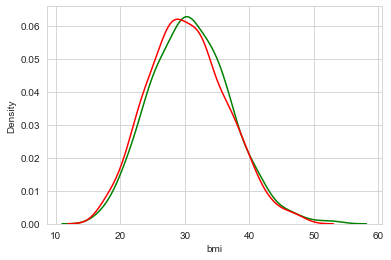

In [57]:
sns.distplot(bmi_male, color='green', hist=False)
sns.distplot(bmi_female, color='red', hist=False)

In [58]:
df_female.bmi.mean()

30.377749244713023

In [59]:
df_male.bmi.mean()

30.943128698224832

In [61]:
# get statistic and p value
t_statistic_2, p_value_2 = ttest_ind(bmi_male, bmi_female)
print("t-stats = ",t_statistic_2, ", p-value = ", p_value_2)

t-stats =  1.696752635752224 , p-value =  0.08997637178984932


In [62]:
if p_value_2 <alpha :
    print("Conclusion: Since p-value {} is less than alpha {} ". format (p_value_2,alpha) )
    print("Reject Null Hypothesis that there is no difference in bmi of men and bmi of female.")
    
else:
    print("Conclusion: Since p-value {} is greater than alpha {} ". format (p_value_2,alpha))
    print("Failed to Reject Null Hypothesis that there is difference in bmi of men and bmi of female .")

Conclusion: Since p-value 0.08997637178984932 is greater than alpha 0.05 
Failed to Reject Null Hypothesis that there is difference in bmi of men and bmi of female .


**Step 5:** Decide to reject or accept null hypothesis
We fail to reject the null hypothesis and can conclude that there is no difference between BMI of Female and BMI of Male.



 
### 3. Is the proportion of smokers significantly different across different regions?

**Step 1:** Define the null and alternative hypothesis.

H<sub>0</sub>: Smokers proportions is not significantly different across different regions.

H<sub>a</sub>: Smokers proportions is different across different regions.

**Step 2:** Decide the significance level. If P values is less than alpha, reject the null hypothesis.

α = 0.05

**Step 3:** Identify the test

Since the comparison is betweem two different categorical variables, smoker and different region. So a Chi-squared test is performed.

**Step 4:** Calculate the test-statistics and p-value

In [64]:
contigency= pd.crosstab(df.region, df.smoker)
contigency

smoker,no,yes
region,,
northeast,257,67
northwest,267,58
southeast,273,91
southwest,267,58


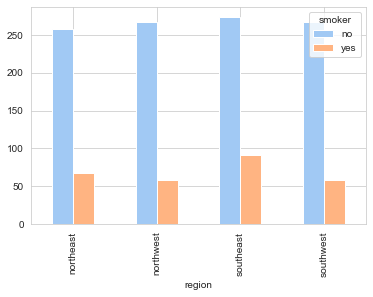

In [66]:
contigency.plot(kind='bar');

In [70]:
chi2, pval, dof, exp_freq = chi2_contingency(contigency, correction = False)
print('chi-square statistic: {} , \nPvalue: {} , \nDegree of freedom: {} ,\nexpected frequencies: {} '.format(chi2, pval, dof, exp_freq))

chi-square statistic: 7.343477761407071 , 
Pvalue: 0.06171954839170541 , 
Degree of freedom: 3 ,
expected frequencies: [[257.65022422  66.34977578]
 [258.44544096  66.55455904]
 [289.45889387  74.54110613]
 [258.44544096  66.55455904]] 


In [71]:
if (pval < 0.05):
    print('Reject Null Hypothesis')
else:
    print('Failed to reject Null Hypothesis')

Failed to reject Null Hypothesis


**Step 5:** Decide to reject or accept null hypothesis

We failed to reject the null hypothesis and conclude that Smoker proportions is not significantly different across different regions.



### 4. Is the mean BMI of women with no children, one child, and two children the same? Explain your answer with statistical evidence.

**Step 1:** Define the null and alternative hypothesis.

H<sub>0</sub>: μ<sub>1</sub>=μ<sub>2</sub>=μ<sub>3</sub> The mean BMI of women with no children, one child, two children is same.

H<sub>a</sub>: Atleast one of mean BMI of women is not same.

**Step 2:** Decide the significance level. If P values is less than alpha, reject the null hypothesis.

α = 0.05

**Step 3:** Identify the test

One-way ANOVA - Equality of population through variances of samples.

**Step 4:** Calculate the test-statistics and p-value

In [72]:
# Filtering data of only women with 0, 1 and 2 children
df_female_child = df_female.loc[df_female['children']<=2]
df_female_child.head()

,age,sex,bmi,children,smoker,BMIGroup,AgeBin,region,charges
0,19,female,27.90,0,yes,25-35,18-28,southwest,16884.92400
5,31,female,25.74,0,no,25-35,28-38,southeast,3756.62160
6,46,female,33.44,1,no,25-35,38-48,southeast,8240.58960
9,60,female,25.84,0,no,25-35,58-68,northwest,28923.13692
11,62,female,26.29,0,yes,25-35,58-68,southeast,27808.72510


In [73]:
df_female_child.groupby([df_female_child.children]).mean().bmi

children
0    30.361522
1    30.052658
2    30.649790
Name: bmi, dtype: float64

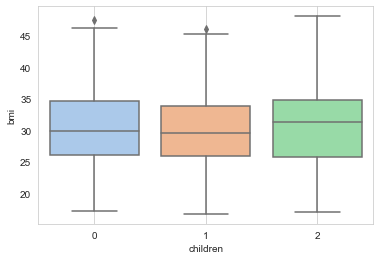

In [74]:
sns.boxplot(x="children", y="bmi", data=df_female_child)
plt.grid()
plt.show()

In [82]:
formula = 'bmi ~ C(children)'
model = ols(formula, df_female_child).fit()
aov_table = anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(children),2.0,24.590123,12.295062,0.334472,0.715858
Residual,563.0,20695.661583,36.759612,NaN,NaN


**Step 5:** Decide to reject or accept null hypothesis

P value is 0.715858 and it is greater than aplha(0.05) therefore, we fail to reject the null hypothesis and conclude that mean BMI of women with no children, one child and two children is same.